# 날씨 빅데이터콘테스트 EDA-weather-data
[날씨 빅데이터 콘테스트]https://bd.kma.go.kr/contest/sub_04.do <br>
[날씨마루] https://bd.kma.go.kr/kma2019/dta/reqst/KBP51001.do?pageNum=5&menuCd=F040201020 <br>
[구글드라이브-데이터]https://drive.google.com/drive/folders/1RO_tBYRFGi-nXWX1Ujb4c8h6gebuCAfp <br>
[기상자료 개방포털] https://data.kma.go.kr/data/grnd/selectAsosRltmList.do?pgmNo=36&tabNo=1 <br>

### 분석 주제
공장 내 철강 제품의 결로 발생 예측 모형 개발
* 24, 48시간 후 결로 발생 예측 및 예측경보 시스템 운영방안 제시

### 분석 데이터
> 1. 기상데이터
    * 날씨마루, 기상자료개방 포털
> 2. 현대제철 공장 (당진1공장, 당진2공장)
    * 결로발생여부 : 내/외부 기온, 습도, 코일온도 
        * 1: 발생, 0:미발생
    * 데이터 기간 : 2016.4.1 ~ 2020.3.31

### 정확도 검증
* 2019.4.1 ~ 2020.3.31 중 특정시점 기준 24,48시간 후 결로발생 여부 (0,1)

### 분석 방향
1) 과거 기상 데이터로 24시간, 48시간 후의 기상 데이터 예측 - 시계열 문제 <br>
2) 1에서 예측한 기상 데이터로 공장의 기상 상황 예측 - 회귀 <br>
3) 2에서 예측한 공장 기상 데이터로 결로 여부 예측 - 분류 <br>

1. feature : 과거 기상 데이터, target : 24시간, 48시간 뒤의 미래 기상 데이터
2. feature : 1에서 예측한 미래 기상 데이터, target : 공장의 미래 기상 데이터
3. feature: 2에서 예측한 공장의 미래 기상 데이터, target : 미래의 결로 여부

### 테이블 설명
> * plant1_train
    * 공장1의 결로발생 데이터(학습용)
    * 기간 : 2016-04-01 0:00 ~ 2019-03-31 23:50
> * plant2_train
    * 공장2의 결로발생 데이터(학습용)
    * 기간 : 2016-04-01 0:00 ~ 2019-03-31 23:50
> * plant_test
    * 검증용 데이터
    * 2019-04-01 0:00 ~ 2020-03-31 23:50
    * 예측 정확도 검증을 위한 결로발생 여부  비공개

### 날씨데이터 
(참고) 2공장은 당진AWS, 1공장은 신평AWS과 가까움. 서산ASOS는 두공장과 조금 멈<br>

* 당진 = 기온, 습도, 상대습도, 강수, 지면온도
* 신평 = 기온, 습도, 상대습도, 강수, 지면온도
* 서산 = 기온, 습도, 강수, 이슬점온도, 지면온도

### 진행방안
* 공장1,2(plant1 , plant2) 별로, 그리고 공장위치 (loc) 별로 다르다고 할 수 있는지 통계적 검정
    * 공장위치별로 다르게 모델링 한 근거를 댈 때 통계적 검정이 필요.
* RETAIN 모델
    * 시계열분석에 적합한 모델. RNN기반, 해석력 좋음.
    * RETAIN모델을 통해 추세의 유사성 뿐만 아니라, 기온/습도/이슬점이 실제 결로에 미치는 영향력의 크기를 시점별로 확인 가능.
* 결로현상 같은 비율상 적게 나타나는 값을 예측하기에 좋은 모델? 방안? 구상하는게 중요해보임.
* 변수별 영향력 시각화
* 다중공선성 문제 고려
    * 공장 내부온도랑 코일표면온도와 같이 상관관계 높은 변수들 중 어떤변수 뽑아낼지

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
from itertools import cycle
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [2]:
# jupyter notebook cell 너비 조절
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

import warnings
warnings.filterwarnings("ignore")

In [3]:
# 한글깨짐 문제
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

#### 데이터 불러오기


In [154]:
plant1_train=pd.read_csv('./data/plant1_train.csv',index_col=[0],parse_dates=['plant1_train.mea_ddhr'])
plant2_train=pd.read_csv('./data/plant2_train.csv',index_col=[0],parse_dates=['plant2_train.mea_ddhr'])
plant_test=pd.read_csv('./data/plant_test.csv',index_col=[0],parse_dates=['plant_test.mea_ddhr'])

# 당진
dangjin_humid=pd.read_csv('./data/dangjin_humid.csv',index_col=None)
dangjin_rain=pd.read_csv('./data/dangjin_rain.csv',index_col=None)
dangjin_tem=pd.read_csv('./data/dangjin_tem.csv',index_col=None)

# 신평
shinpyung_humid=pd.read_csv('./data/shinpyung_humid.csv',index_col=None)
shinpyung_rain=pd.read_csv('./data/shinpyung_rain.csv',index_col=None)
shinpyung_tem=pd.read_csv('./data/shinpyung_tem.csv',index_col=None)

# 서산
seosan_tem=pd.read_csv('./data/asos_서산_시간별.csv',index_col=None,parse_dates=['일시'])

# test데이터셋과 동일하게 train 데이터 전처리
plant_train=pd.read_csv('./data/plant_train.csv',index_col=[0])

#### 컬럼명 전처리

In [155]:
# 날씨 컬럼명 정리
dangjin = [dangjin_tem, dangjin_rain, dangjin_humid]
seosan=[seosan_tem]

for d in dangjin:
    d.columns = [col.split('.')[1] for col in d.columns]    
    d.rename(columns={'tm':'datetime'}, inplace=True)    

In [156]:
# 공장 컬럼명 정리
plant = [plant1_train, plant2_train, plant_test]

for p in plant:
    p.columns = [col.split('.')[1] for col in p.columns]    
    p.rename(columns={'mea_ddhr':'datetime'}, inplace=True)    

In [28]:
# 다른 방법 
dangjin = [dangjin_tem, dangjin_rain, dangjin_humid]
i = 0
col_n =[]
for d in dangjin:
    col_n.append([])
    for col in d.columns:
        col_n[i].append( col.split('.')[1] )

    print(col_n[i])
    i += 1

['tm', 'aws_id', 'ta', 'ta_hmi', 'ta_avg', 'ta_qcm', 'ta_max', 'ta_max_mi', 'ta_min', 'ta_min_mi']
['tm', 'aws_id', 're_sum', 're_qcm', 'rn_day', 'rn_day_mi', 'rn_hr1', 'rn_hr1_mi', 'rn_60m_max', 'rn_60m_max_mi', 'rn_60m_qcm', 'rn_15m_max', 'rn_15m_max_mi', 'rn_15m_qcm', 'rn01_hr1', 'rn01_hr1_mi']
['tm', 'aws_id', 'hm', 'hm_hmi', 'hm_avg', 'hm_qcm', 'hm_max', 'hm_max_mi', 'hm_min', 'hm_min_mi']


### 시간별 데이터분리
**[plant1]** 
* 년도별로 봤을 때, 결로수가 2018년이 loc1,loc2,loc3 모두 가장 많음
* 월별로 봤을 때, 겨울인 12월과 2월이 많음

**[plant2]** 
* 년도별로 봤을 때, 마찬가지로 2018년이 결로가 가장 많음.
* 마찬가지로, 월별로 봤을 때 겨울이 많음

In [157]:
# 날짜별 , 시간별 추이
plant1_train["year"] = plant1_train['datetime'].dt.year
plant1_train["month"] = plant1_train['datetime'].dt.month
plant1_train["day"] = plant1_train['datetime'].dt.day
plant1_train["hour"] =plant1_train['datetime'].dt.hour
plant1_train["minute"] =plant1_train['datetime'].dt.minute
plant1_train["second"] = plant1_train['datetime'].dt.second

In [158]:
# 날짜별 , 시간별 추이
plant2_train["year"] = plant2_train['datetime'].dt.year
plant2_train["month"] = plant2_train['datetime'].dt.month
plant2_train["day"] = plant2_train['datetime'].dt.day
plant2_train["hour"] =plant2_train['datetime'].dt.hour
plant2_train["minute"] =plant2_train['datetime'].dt.minute
plant2_train["second"] = plant2_train['datetime'].dt.second

In [84]:
# plant1 의 년도별 loc1,loc2,loc3에서의 결로 수
year_cond1=pd.concat([plant1_train.query('cond_loc1==1').groupby(['year'])['datetime'].count(),\
          plant1_train.query('cond_loc2==1').groupby(['year'])['datetime'].count(),\
          plant1_train.query('cond_loc3==1').groupby(['year'])['datetime'].count()],axis=1).reset_index()
year_cond1.columns=['year','loc1','loc2','loc3']

# plant2 의 년도별 loc1,loc2,loc3에서의 결로 수
year_cond2=pd.concat([plant2_train.query('cond_loc1==1').groupby(['year'])['datetime'].count(),\
          plant2_train.query('cond_loc2==1').groupby(['year'])['datetime'].count(),\
          plant2_train.query('cond_loc3==1').groupby(['year'])['datetime'].count()],axis=1).reset_index()
year_cond2.columns=['year','loc1_p2','loc2_p2','loc3_p2']

# plant1, plant2 결합
pd.merge(year_cond1, year_cond2,on="year")

,year,loc1,loc2,loc3,loc1_p2,loc2_p2,loc3_p2
0,2016,9,17,35,10,8,15.0
1,2017,27,69,120,44,29,4.0
2,2018,221,299,363,158,204,25.0
3,2019,18,102,127,65,36,NaN


In [85]:
# plant1 의 월별 loc1,loc2,loc3에서의 결로 수
month_cond1=pd.concat([plant1_train.query('cond_loc1==1').groupby(['month'])['datetime'].count(),\
          plant1_train.query('cond_loc2==1').groupby(['month'])['datetime'].count(),\
          plant1_train.query('cond_loc3==1').groupby(['month'])['datetime'].count()],axis=1).reset_index()
month_cond1.columns=['month','loc1','loc2','loc3']

# plant2의 월별 loc1,loc2,loc3에서의 결로 수
month_cond2=pd.concat([plant2_train.query('cond_loc1==1').groupby(['month'])['datetime'].count(),\
          plant2_train.query('cond_loc2==1').groupby(['month'])['datetime'].count(),\
          plant2_train.query('cond_loc3==1').groupby(['month'])['datetime'].count()],axis=1).reset_index()
month_cond2.columns=['month','loc1_p2','loc2_p2','loc3_p2']

# plant1, plant2 결합
pd.merge(month_cond1, month_cond2,on="month")

,month,loc1,loc2,loc3,loc1_p2,loc2_p2,loc3_p2
0,1,12.0,21.0,50,16,13,NaN
1,2,36.0,108.0,143,73,48,2.0
2,3,38.0,56.0,62,55,52,8.0
3,4,2.0,23.0,32,4,7,12.0
4,5,34.0,51.0,75,28,61,1.0
5,6,3.0,1.0,1,3,1,1.0
6,11,4.0,48.0,61,9,7,NaN
7,12,146.0,177.0,210,89,88,20.0


In [18]:
### tem_in, hum_in, tem_coil, tem_out, hum_out, dew_in, dew_out 표준화해서 그려보기.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(plant_train[['tem_in','hum_in','tem_coil','tem_out','hum_out','dew_in','dew_out']])
scaled = scaler.transform(plant_train[['tem_in','hum_in','tem_coil','tem_out','hum_out','dew_in','dew_out']])

scaled=pd.DataFrame({'tem_in': scaled[:, 0], 'hum_in': scaled[:, 1],'tem_coil': scaled[:, 1],'tem_out': scaled[:, 1],\
                       'hum_out': scaled[:, 1],'dew_in': scaled[:, 1],'dew_out': scaled[:, 1]}).reset_index(drop=True)
scaled=pd.concat([plant_train['datetime'].reset_index(drop=True),scaled],axis=1)
scaled.head(100)

,datetime,tem_in,hum_in,tem_coil,tem_out,hum_out,dew_in,dew_out
0,2016-04-01 00:00:00,-0.041477,-2.056931,-2.056931,-2.056931,-2.056931,-2.056931,-2.056931
1,2016-04-01 00:00:00,-0.242289,-2.128998,-2.128998,-2.128998,-2.128998,-2.128998,-2.128998
2,2016-04-01 00:00:00,-0.342694,-1.480393,-1.480393,-1.480393,-1.480393,-1.480393,-1.480393
3,2016-04-01 03:00:00,-0.242289,-1.768662,-1.768662,-1.768662,-1.768662,-1.768662,-1.768662
4,2016-04-01 03:00:00,-0.443100,-1.480393,-1.480393,-1.480393,-1.480393,-1.480393,-1.480393
...,...,...,...,...,...,...,...,...
95,2016-04-04 21:00:00,-0.141883,-2.056931,-2.056931,-2.056931,-2.056931,-2.056931,-2.056931
96,2016-04-05 00:00:00,-0.141883,-2.273132,-2.273132,-2.273132,-2.273132,-2.273132,-2.273132
97,2016-04-05 00:00:00,-0.342694,-2.273132,-2.273132,-2.273132,-2.273132,-2.273132,-2.273132
98,2016-04-05 00:00:00,-0.342694,-1.984864,-1.984864,-1.984864,-1.984864,-1.984864,-1.984864


### plant1의 loc별 온도,습도,코일표면온도 box-plot
* loc1,2,3 별로 온도, 습도, 코일표면온도의 box-plot을 통해서 이상치로 보이는 부분들을 결로현상을 결정짓는 부분이라고 봐도되나
    * 이상치가 많은 요인일수록 결로현상에 영향을 미치는 요인으로 해석하는식 ?

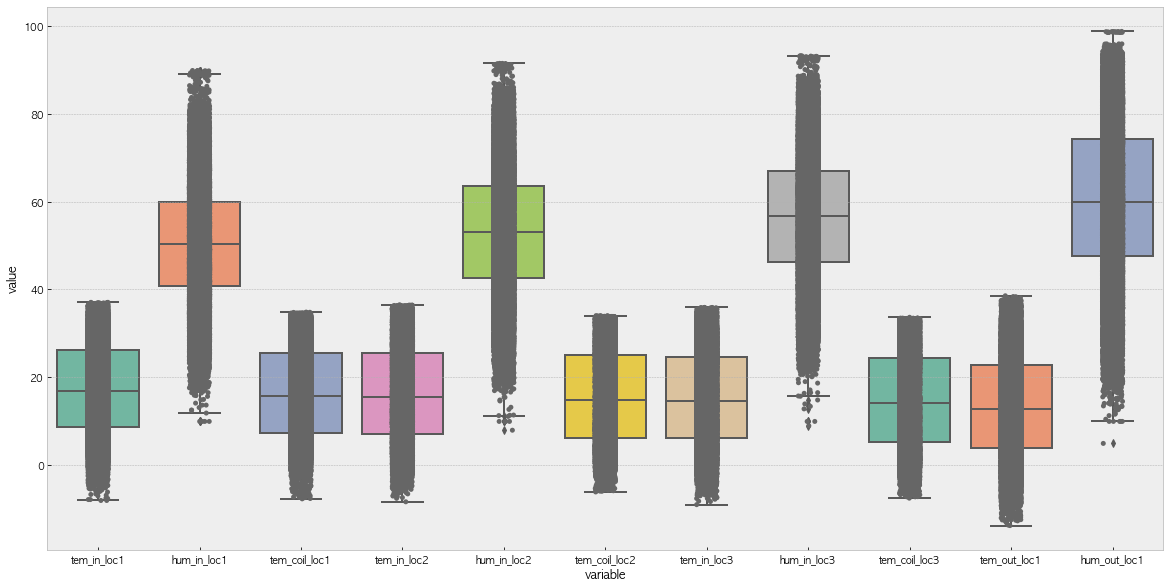

In [112]:
plt.figure(figsize=(20,10))
sns.boxplot(x="variable",y="value", data=plant1_train.iloc[:,1:-9].melt(),palette="Set2")
sns.stripplot(x="variable", y="value", data=plant1_train.iloc[:,1:-9].melt(), jitter=True, color="0.4")
plt.show()

* 습도 데이터의 box-plot이 이상치로 보이는 점들이 있는것으로 보아, 결로여부를 예측하는 데 습도데이터가 영향력이 크다고 판단(?)
    * 결로가 발생한경우가 정상인 경우보다 상당히 적으므로, 결로가 발생했을때의 습도도 정상인경우와 다른 형태(이상치 처럼) 를 띈다고 유추

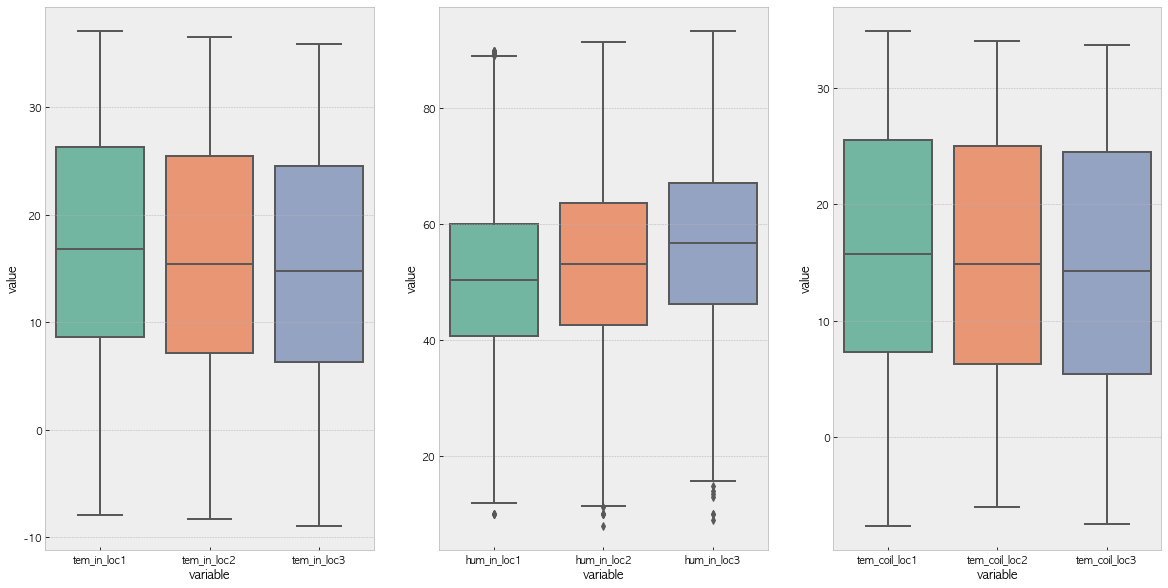

In [122]:
fig,ax=plt.subplots(1,3)
fig.set_size_inches(20,10)
sns.boxplot(x="variable",y="value", data=plant1_train[['tem_in_loc1','tem_in_loc2','tem_in_loc3']].melt(),palette="Set2",ax=ax[0])
sns.boxplot(x="variable",y="value", data=plant1_train[['hum_in_loc1','hum_in_loc2','hum_in_loc3']].melt(),palette="Set2",ax=ax[1])
sns.boxplot(x="variable",y="value", data=plant1_train[['tem_coil_loc1','tem_coil_loc2','tem_coil_loc3']].melt(),palette="Set2",ax=ax[2])

* loc1, loc2, loc3 별 온도,습도,코일표면온도를 봤을 때 loc 별로 온도,습도,코일표면온도 차이를 보임

## 이슬점온도와 결로현상
* 코일표면온도가 실내공기 이슬점보다 낮을 때 결로 생김
    * (이슬점 - 표면온도) > 0

In [159]:
def dew_point_c(t_air_c, rel_humidity):
    """
    celcius로 이슬점 계산 함수. 
    
    *attrs
    t_air_c: Series, float. celcius 온도
    rel_humidity: Series, float. 상대습도 %

    *return: float. 이슬점
    """
    A = 17.27
    B = 237.7
    alpha = ((A * t_air_c) / (B + t_air_c)) + np.log(rel_humidity/100.0)
    
    return (B * alpha) / (A - alpha)

In [160]:
plant_train['dew_in'] = dew_point_c(plant_train['tem_in'], plant_train['hum_in'])
plant_train['dew_out'] = dew_point_c(plant_train['tem_out'], plant_train['hum_out'])

In [161]:
temp_cols = ['tem_in', 'hum_in', 'tem_coil', 'tem_out', 'hum_out','dew_in', 'dew_coil', 'dew_out']

In [15]:
plant_train.head()

,datetime,plant,loc,tem_in,hum_in,tem_coil,tem_out,hum_out,cond,x24h_cond,x48h_cond,dew_in,dew_out
0,2016-04-01 00:00:00,1,1,16.0,24.0,11.0,9.0,42.0,0.0,0.0,0.0,-4.562263,-3.224066
1,2016-04-01 00:00:00,1,2,14.0,23.0,11.0,9.0,42.0,0.0,0.0,0.0,-6.806323,-3.224066
2,2016-04-01 00:00:00,1,3,13.0,32.0,10.0,9.0,42.0,0.0,0.0,0.0,-3.310253,-3.224066
3,2016-04-01 03:00:00,1,1,14.0,28.0,10.0,7.0,59.0,0.0,0.0,0.0,-4.223102,-0.461554
4,2016-04-01 03:00:00,1,2,12.0,32.0,9.0,7.0,59.0,0.0,0.0,0.0,-4.184595,-0.461554


### 결로현상
결로현상이란 물체의 표면에 물방울이 맺히는 현상입니다. <br>
결로현상은 기온차로 발생하는데요. 유리창이나 창틀의 실내측 표면온도가 실내 공기의 이슬점 이하로 떨어질때 미세한 수증기가 창의 표면에 달라붙는 것입니다. <br>
어느 온도의 공기가 그보다 차가운 벽에 접촉해서 기 온이 내려가면 이 공기의 상대습도는 올라갑니다. <br>
결로현상은 주로 겨울에 많이 발생하는데 실내와 실외의 온도차가 크고 실내에는 수중기를 발산시키는 것이 많기 때문입니다. 

In [150]:
cond_y=plant_train.query('cond==1')   # 결로 발생
cond_n=plant_train.query('cond==0') # 결로 미발생

In [17]:
print('결로현상이 발생한 수의 비율 : {} %'.format(round((cond_y.shape[0]/plant_train.shape[0])*100,2)))

결로현상이 발생한 수의 비율 : 0.57 %


In [18]:
print('결로현상 발생하지 않은 수의 비율: {} % '.format(round((cond_n.shape[0]/plant_train.shape[0])*100,2)))

결로현상 발생하지 않은 수의 비율: 98.79 % 


In [19]:
cond_y

,datetime,plant,loc,tem_in,hum_in,tem_coil,tem_out,hum_out,cond,x24h_cond,x48h_cond,dew_in,dew_out
131,2016-04-06 09:00:00,1,3,13.00,84.00,11.00,11.00,45.00,1.0,0.0,1.0,10.358700,-0.476037
178,2016-04-08 09:00:00,1,2,13.00,80.00,10.00,9.00,75.00,1.0,1.0,0.0,9.629510,4.807381
179,2016-04-08 09:00:00,1,3,12.00,82.00,9.00,9.00,75.00,1.0,1.0,0.0,9.021774,4.807381
182,2016-04-08 12:00:00,1,3,13.00,80.00,10.00,12.00,63.00,1.0,0.0,0.0,9.629510,5.174198
197,2016-04-09 03:00:00,1,3,13.00,77.00,10.00,9.00,80.00,1.0,0.0,0.0,9.061264,5.735506
...,...,...,...,...,...,...,...,...,...,...,...,...,...
171669,2019-03-21 02:30:00,2,1,11.68,84.83,10.06,10.43,99.48,1.0,0.0,0.0,9.212235,10.351831
171670,2019-03-21 02:30:00,2,2,12.53,83.91,10.48,10.43,99.48,1.0,0.0,0.0,9.882534,10.351831
171672,2019-03-21 02:40:00,2,1,11.68,84.83,10.18,10.21,99.42,1.0,0.0,0.0,9.212235,10.122943
171675,2019-03-21 02:50:00,2,1,11.59,84.86,10.10,9.94,99.45,1.0,0.0,0.0,9.129254,9.857636


In [146]:
# 코일표면온도가 이슬점온도보다 낮을경우=> 100% 결로현상 발생
plant_train[plant_train.dew_in>plant_train.tem_coil]['cond'].value_counts()

1.0    900
Name: cond, dtype: int64

In [144]:
# 코일표면온도가 이슬점온도보다 높을경우 => 99.7%가 결로현상 미발생, 단 0.32%만 결로현상 발생.
plant_train[plant_train.dew_in<=plant_train.tem_coil]['cond'].value_counts()

0.0    348361
1.0      1105
Name: cond, dtype: int64

## 1) 과거 기상 데이터로 24시간, 48시간 후의 기상 데이터 예측 - 시계열 문제 
(참고) https://tykimos.github.io/warehouse/2018-5-16-ISS_Plant_DeepLearning_Model_in_SNRC_kbk_file.pdf <br>
* 이동평균, 회귀
* 목적 :
    * 즉, 2016-04-01  ~ 2019-03-31 의 3년 날씨 데이터로 2019-04-01 ~ 2020-03-29 (1년) 날씨를 예측하는 것
    * 주어진 날씨데이터는 시간별 데이터고, 예측할 날씨는 30분 단위로 예측해야함. 
        * 입력데이터를 30분단위로 처리해서 train 시켜야 하나 

In [173]:
seosan_tem.shape

(35198, 37)

In [183]:
# 2016-04-01 ~ 2020-04-07
### 2019-03-31 까지의데이터만 사용 가능. (총 3년) 
### 즉, 2016-04-01  ~ 2019-03-31 의 3년 날씨 데이터로 2019-04-01 ~ 2020-03-29 (1년) 날씨를 예측하는 것이 목적
seosan_tem.set_index('일시').head()

,지점,지점명,기온(°C),기온 QC플래그,강수량(mm),강수량 QC플래그,풍속(m/s),풍속 QC플래그,풍향(16방위),풍향 QC플래그,습도(%),습도 QC플래그,증기압(hPa),이슬점온도(°C),현지기압(hPa),현지기압 QC플래그,해면기압(hPa),해면기압 QC플래그,일조(hr),일조 QC플래그,일사(MJ/m2),적설(cm),3시간신적설(cm),전운량(10분위),중하층운량(10분위),운형(운형약어),최저운고(100m ),시정(10m),지면상태(지면상태코드),현상번호(국내식),지면온도(°C),지면온도 QC플래그,5cm 지중온도(°C),10cm 지중온도(°C),20cm 지중온도(°C),30cm 지중온도(°C)
일시,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-04-01 00:00:00,129,서산,8.8,0.0,NaN,NaN,1.5,0.0,50.0,0.0,41.0,0.0,4.6,-3.7,1012.1,0.0,1015.6,0.0,NaN,9.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,2000.0,NaN,NaN,4.0,0.0,NaN,NaN,NaN,NaN
2016-04-01 01:00:00,129,서산,9.2,0.0,NaN,NaN,1.2,0.0,50.0,0.0,34.0,0.0,4.0,-5.8,1011.7,0.0,1015.2,0.0,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000.0,NaN,NaN,3.4,0.0,NaN,NaN,NaN,NaN
2016-04-01 02:00:00,129,서산,9.2,0.0,NaN,NaN,1.1,0.0,20.0,0.0,33.0,0.0,3.8,-6.2,1011.3,0.0,1014.8,0.0,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000.0,NaN,NaN,3.3,0.0,NaN,NaN,NaN,NaN
2016-04-01 03:00:00,129,서산,7.5,0.0,NaN,NaN,0.4,0.0,0.0,0.0,40.0,0.0,4.2,-5.2,1011.4,0.0,1014.9,0.0,NaN,9.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,2000.0,0.0,NaN,2.8,0.0,NaN,NaN,NaN,NaN
2016-04-01 04:00:00,129,서산,4.8,0.0,NaN,NaN,0.6,0.0,110.0,0.0,56.0,0.0,4.8,-3.2,1011.6,0.0,1015.2,0.0,NaN,9.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,2000.0,NaN,NaN,1.8,0.0,NaN,NaN,NaN,NaN


In [180]:
# 2019-04-01 ~ 2020-03-29
plant_test.head()

,datetime,plant,loc,tem_in,hum_in,tem_coil,tem_out_loc1,hum_out_loc1,x24h_tma,x24h_cond_loc,x48h_tma,x48h_cond_loc
1,2019-04-01 00:00:00,2,3,8.17,40.42,10.10,4.20,54.82,2019-04-02 0:00,NaN,2019-04-03 0:00,NaN
2,2019-04-01 04:30:00,1,2,10.03,48.81,10.79,6.09,59.34,2019-04-02 4:30,NaN,2019-04-03 4:30,NaN
3,2019-04-01 10:30:00,2,3,9.45,40.93,9.07,12.26,32.14,2019-04-02 10:30,NaN,2019-04-03 10:30,NaN
4,2019-04-01 11:00:00,1,1,12.32,34.13,10.86,12.32,28.27,2019-04-02 11:00,NaN,2019-04-03 11:00,NaN
5,2019-04-01 13:30:00,2,1,11.28,22.65,8.76,12.01,19.84,2019-04-02 13:30,NaN,2019-04-03 13:30,NaN
